In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import PIL
from PIL import ImageFile

import os
from datetime import datetime
import traceback


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# testDataPath = "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/test.zip"
# validDataPath = "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/valid.zip"

# if os.path.exists(testDataPath) & !os.path.exists("/content/drive/MyDrive/ENEL 645 Group Work/Final Project/test"):
#     !unzip -q "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/test.zip" -x '__MACOSX/*' -d "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/test"

# if os.path.exists(validDataPath) & !os.path.exists("/content/drive/MyDrive/ENEL 645 Group Work/Final Project/valid"):
#     !unzip -q "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/valid.zip" -x '__MACOSX/*' -d "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/valid"

In [ ]:
modelPath = "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/fine_tuned_model.pth"

testDataPath = "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/test/test"
validDataPath = "/content/drive/MyDrive/ENEL 645 Group Work/Final Project/valid/valid"

In [ ]:
# files = os.listdir("/content/drive/MyDrive/ENEL 645 Group Work/Final Project")
# print(files)

In [ ]:
#Now Evaluate Model on Validation/ Test Sets
#Create Evaulation Metric(acc/preci/F1-score)
#Analyze model performance using confusioin matrix
#Generate smaple predictions and vizs

In [ ]:
class PretrainedWildfireNet(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedWildfireNet, self).__init__()
        # Load the pretrained ResNet50 model
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Freeze all parameters by default
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer with the custom classifier
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# transformer = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_dataset = datasets.ImageFolder(root=testDataPath, transform=transformer)
# valid_dataset = datasets.ImageFolder(root=validDataPath, transform=transformer)

# batch_size = 32
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,num_workers=2)

# class_names = test_dataset.classes
# print(class_names)

In [ ]:
model = PretrainedWildfireNet(num_classes=2).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [ ]:
model.load_state_dict(torch.load(modelPath, map_location=device, weights_only=True))
model.eval()

PretrainedWildfireNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
# Set up paths to data directories
# data_dir = "/home/pahul.brar/TransferLearning/FinalProject/Data"
# train_dir = os.path.join(data_dir, "train")
# val_dir = os.path.join(data_dir, "valid")
# test_dir = os.path.join(data_dir, "test")

# Data transformations for training and evaluation
# The images are all 350x350, but the pre-trained model expect 224x224 images so they've been resized
transform = {
    "eval": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet statistics
    ])
}

# Sometimes there was an error given that an image was corrupted, but I couldn't find it
# Custom image loader that can handle corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True  # This is needed to handle truncated images
def safe_PIL_loader(path):
    try:
        with open(path, 'rb') as f:
            img = PIL.Image.open(f)
            return img.convert('RGB')
    except Exception as e:
        print(f"Warning: Error loading image {path}: {e}")
        return PIL.Image.new('RGB', (224, 224), (0, 0, 0)) # Return a black image of the expected size

# Custom loader to avoid corruption
class SafeImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(SafeImageFolder, self).__init__(root=root, transform=transform, loader=safe_PIL_loader)

# Dataset objects from the SafeImageFolder class
datasets_dict = {
    # "train": SafeImageFolder(train_dir, transform=transform["train"]),
    "val": SafeImageFolder(validDataPath, transform=transform["eval"]),
    "test": SafeImageFolder(testDataPath, transform=transform["eval"])
}

# Class information
# print(f"Classes: {datasets_dict['train'].classes}")
# print(f"Class after mapping: {datasets_dict['train'].class_to_idx}")

# Create DataLoaders
num_workers = 2 # Reduce num_workers to avoid warnings and potential freezing
batch_size = 64
dataloaders = {
    # "train": DataLoader(datasets_dict["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    "val": DataLoader(datasets_dict["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers),
    "test": DataLoader(datasets_dict["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

class_names = datasets_dict["test"].classes
print(class_names)

['nowildfire', 'wildfire']


In [ ]:
# def evaluate_model(model, dataloader):
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Calculate accuracy
#     accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
#     print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# evaluate_model(model, dataloaders["test"])

In [ ]:
def evaluate_model(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    cm = confusion_matrix(all_labels, all_preds)

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    class_metrics = {}
    for class_name in class_names:
        if class_name in report:
            class_metrics[class_name] = {
                'precision': report[class_name]['precision'],
                'recall': report[class_name]['recall'],
                'f1-score': report[class_name]['f1-score'],
                'support': report[class_name]['support']
            }

            metrics_df = pd.DataFrame(class_metrics).transpose()

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'metrics_df': metrics_df,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels
    }


print("Evaluating model")
results = evaluate_model(model, dataloaders["test"], class_names)

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"F1 Score (weighted): {results['f1_score']:.4f}")
print(f"Precision (weighted): {results['precision']:.4f}")
print(f"Recall (weighted): {results['recall']:.4f}")

Evaluating model

Model Performance Metrics:
Accuracy: 0.9883
F1 Score (weighted): 0.9883
Precision (weighted): 0.9884
Recall (weighted): 0.9883


In [ ]:
# Display detailed classification report
print("\nDetailed Classification Report:")
pd.DataFrame(results['metrics_df'])


Detailed Classification Report:


,precision,recall,f1-score,support
nowildfire,0.979734,0.994326,0.986976,2820.0
wildfire,0.995346,0.983333,0.989303,3480.0


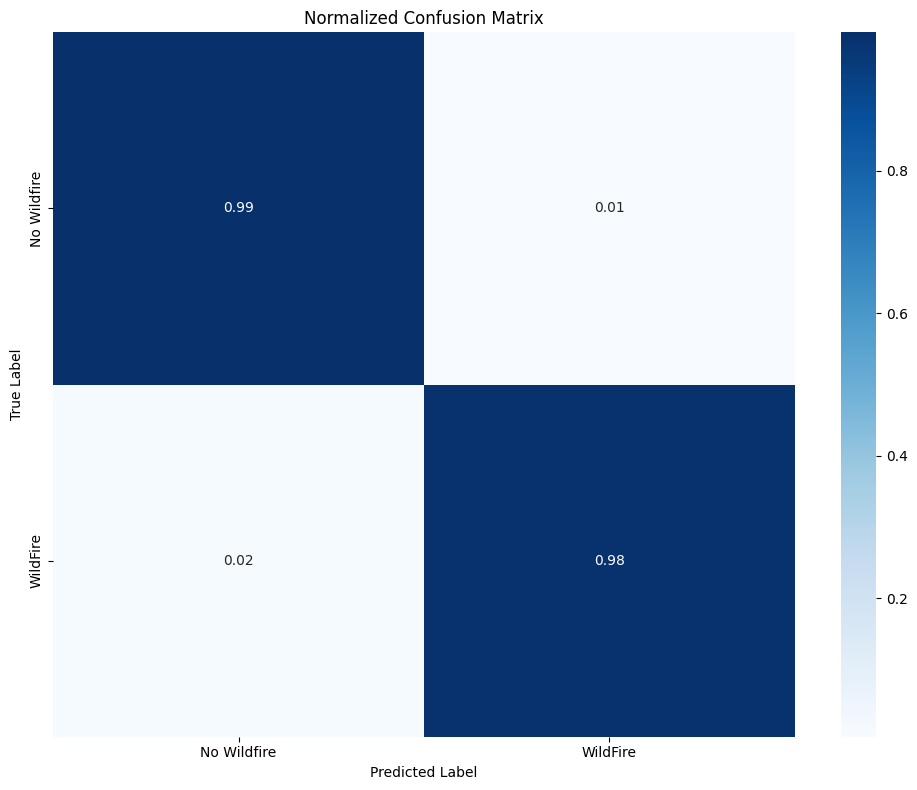

In [ ]:
# Plot confusion matrix
classNames= ['No Wildfire', 'WildFire']
plt.figure(figsize=(10, 8))
cm = results['confusion_matrix']
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classNames, yticklabels=classNames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

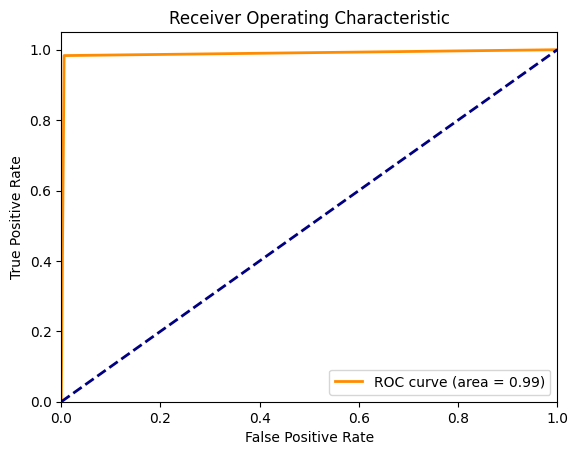

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


predictions = results['predictions']
labels = results['labels']


fpr, tpr, thresholds = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


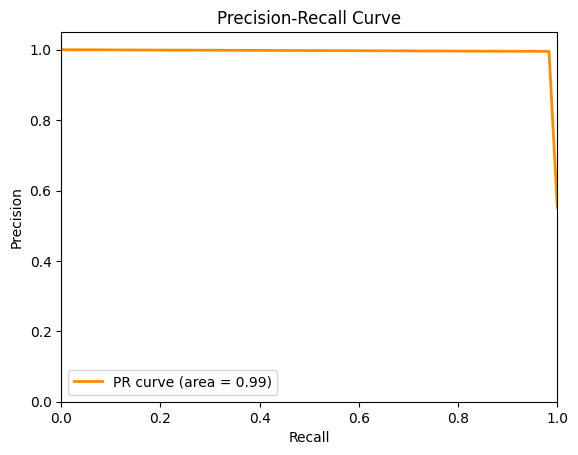

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

predictions = results['predictions']
labels = results['labels']

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(labels, predictions)
average_precision = average_precision_score(labels, predictions)

# Plot PR curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {average_precision:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


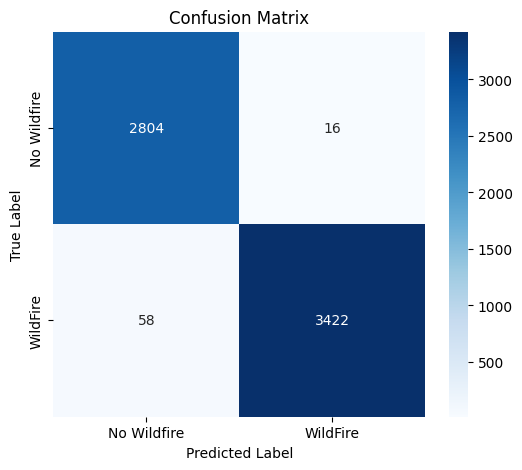

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(results['confusion_matrix'], classNames)


<Figure size 1000x600 with 0 Axes>

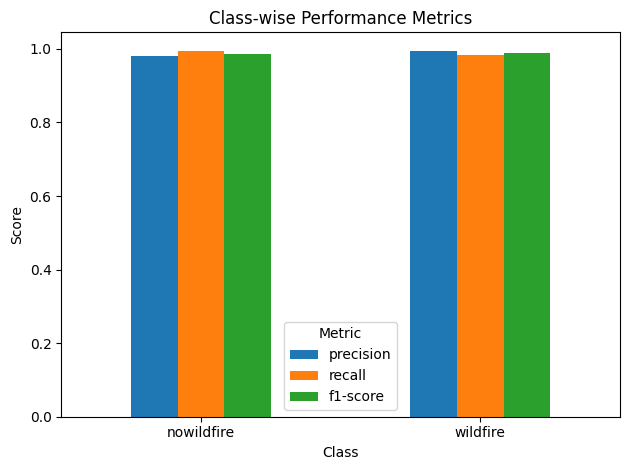

In [ ]:
import matplotlib.pyplot as plt
metrics_df = results['metrics_df']

plt.figure(figsize=(10, 6))
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Class-wise Performance Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


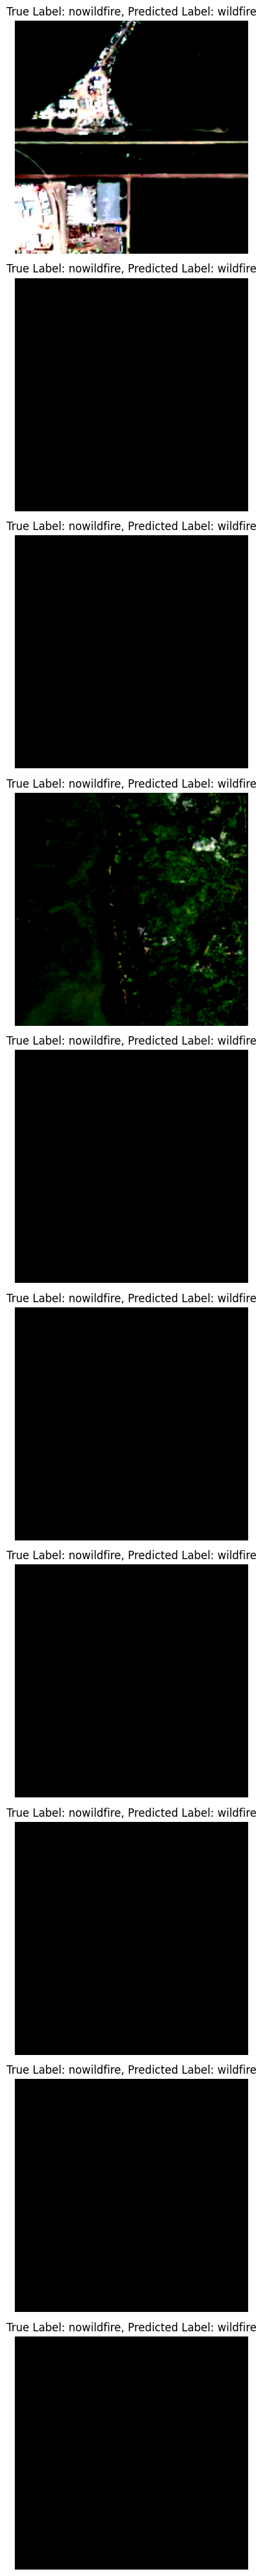

In [34]:

import numpy as np
import matplotlib.pyplot as plt

predictions = results['predictions']
labels = results['labels']

misclassified_indices = np.where(np.array(predictions) != np.array(labels))[0]

# Plot some misclassified samples
num_samples_to_plot = min(len(misclassified_indices), 10) # Adjust as needed
plt.figure(figsize=(10, 4 * num_samples_to_plot))

for i, index in enumerate(misclassified_indices[:num_samples_to_plot]):
    image, true_label = datasets_dict["test"][index]
    predicted_label = predictions[index]

    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"True Label: {class_names[true_label]}, Predicted Label: {class_names[predicted_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


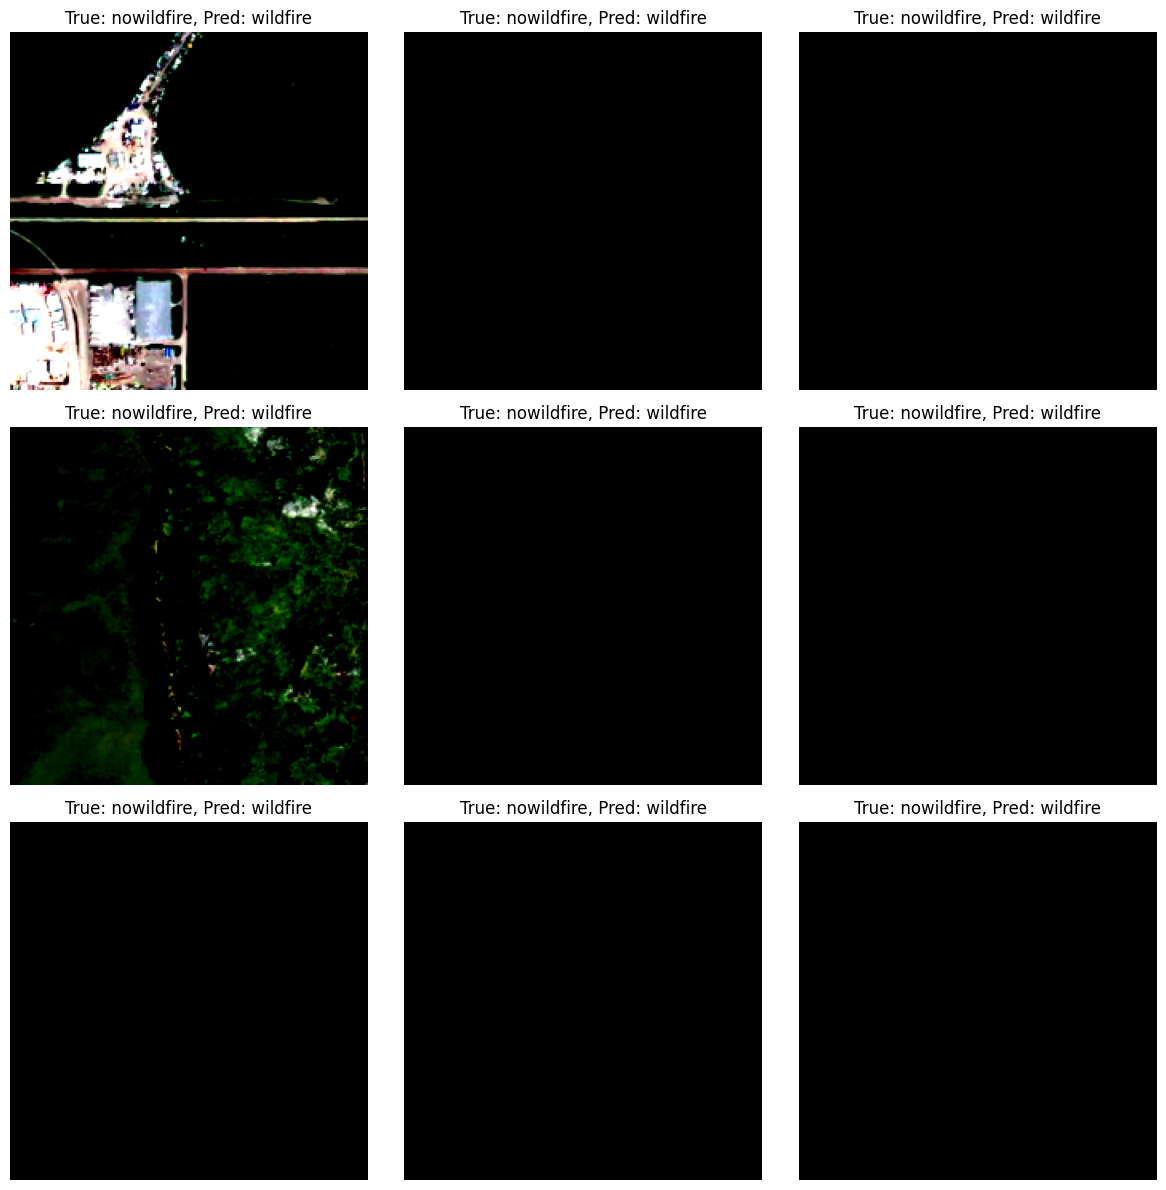

In [33]:
import matplotlib.pyplot as plt
import numpy as np

predictions = results['predictions']
labels = results['labels']

misclassified_indices = np.where(np.array(predictions) != np.array(labels))[0]

num_samples_to_plot = min(len(misclassified_indices), 9)
cols = 3
rows = (num_samples_to_plot + cols - 1) // cols

plt.figure(figsize=(12, 4 * rows))

for i, index in enumerate(misclassified_indices[:num_samples_to_plot]):
    image, true_label = datasets_dict["test"][index]
    predicted_label = predictions[index]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()